<a href="https://colab.research.google.com/github/CharlotteY2003/MIT-Futuremakers/blob/main/7_23_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.layers import *
from keras.models import Sequential
import re
import collections
from pathlib import Path
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers
from keras.optimizers import RMSprop
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Helper functions

In [2]:
NB_WORDS = 1000 #num words we'll put in dictionary
NB_START_EPOCHS = 20 #num epochs for training
BATCH_SIZE = 512
MAX_LEN = 20 #Max num words in sequence

In [3]:
def deep_model(model, X_train, y_train, X_val, y_val):
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=BATCH_SIZE, epochs=NB_START_EPOCHS, 
                      verbose=0)
  return history

In [4]:
def eval_metric(model, history, metric_name):
  metric = history.history[metric_name]
  val_metric = history.history['val_' + metric_name]

  e = range(1,NB_START_EPOCHS+1)

  plt.plot(e, metric, 'bo', label='train ' + metric_name)
  plt.plot(e, val_metric, 'b', label='val ' + metric_name)
  plt.xlabel('Epochs')
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()


In [5]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
  model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=epoch_stop, 
                      verbose=0)
  results = model.evaluate(X_test, y_test)
  print()
  print('Test accuracy: ' + str(results[1]))
  return results

In [6]:
def remove_stopwords(input_text):
  clean_words = []
  stopwords_list = stopwords.words('english')
  whitelist = ["n't", "not", "no"] #stopwords that may indicate semantic meaning
  words = input_text.split()
  for word in words:
    if (word not in stopwords_list or word in whitelist) and len(word) > 1:
      clean_words.append(word)
  return " ".join(clean_words)

In [7]:
def remove_mentions(input_text):
  return re.sub(r'@\w+', '', input_text)

In [8]:
def compare_models_by_metric(model_1, model_2, model_hist1, model_hist2, metric):
  metric_model1 = model_hist1.history[metric]
  metric_model2 = model_hist2.history[metric]

  e = range(1, NB_START_EPOCHS+1)

  metrics_dict = {
      'acc': 'Training Accuracy',
      'loss': 'Training Loss',
      'val_acc': 'Validation Accuracy',
      'val_loss': 'Validation Loss'
  }

  metric_label = metrics_dict[metric]

  plt.plot(e, metric_model1, 'bo', label=model_1.name)
  plt.plot(e, metric_model2, 'b', label=model_2.name)
  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend()
  plt.show

In [9]:
def optimal_epoch(model_hist):
  min_epoch = np.argmin(model_hist.history['val_loss']) + 1
  print('Minimum validation loss reached at ' + str(min_epoch))
  return min_epoch

#Data preprocessing

In [10]:
data = pd.read_csv('Tweets.csv')

In [11]:
data = data.reindex(np.random.permutation(data.index))
data = data[['text', 'airline_sentiment']]
data.text = data.text.apply(remove_stopwords).apply(remove_mentions)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data.text, data.airline_sentiment, test_size = .1, random_state = 37)

In [13]:
tk = Tokenizer(num_words=NB_WORDS, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True, char_level=False, split = ' ')
tk.fit_on_texts(X_train)

In [14]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

In [15]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.fit_transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [16]:
X_train_rest, X_val, y_train_rest, y_val = train_test_split(X_train_oh, y_train_oh, test_size=.1, random_state=37)

#Base Model



In [17]:
base_model = Sequential()
base_model.add(Dense(64, activation='relu', input_shape=(NB_WORDS,), name = "Baseline_model"))
base_model.add(Dense(64, activation='relu'))
base_model.add(Dense(3, activation='softmax'))

Minimum validation loss reached at 5


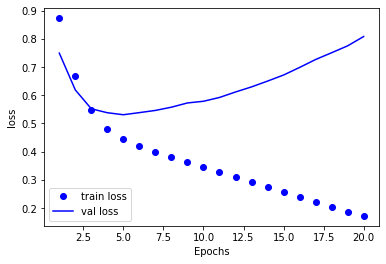

In [18]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_val, y_val)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

#Reduced Model

In [19]:
reduced_model = Sequential()
reduced_model.add(Dense(16, activation='relu', input_shape=(NB_WORDS,), name = "Reduced_model"))
reduced_model.add(Dense(3, activation='softmax'))

Minimum validation loss reached at 13


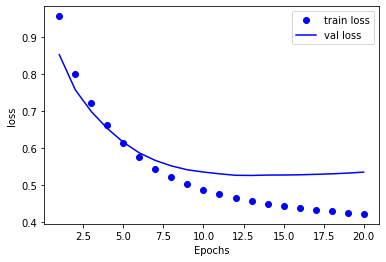

In [20]:
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_val, y_val)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model,reduced_history,'loss')

#Comparison

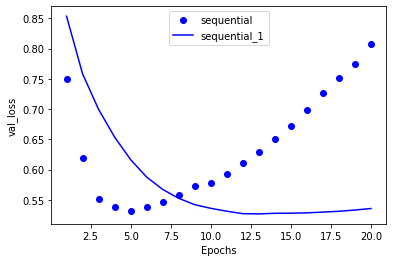

In [21]:
compare_models_by_metric(base_model,reduced_model,base_history,reduced_history,'val_loss')

#Regularization Model

In [32]:
reg_model = Sequential()
reg_model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(.001), input_shape=(NB_WORDS,), name='L2_Regularization_model'))
reg_model.add(Dense(64,activation='relu', kernel_regularizer=regularizers.l2(.001)))
reg_model.add(Dense(3, activation='softmax'))

Minimum validation loss reached at 10


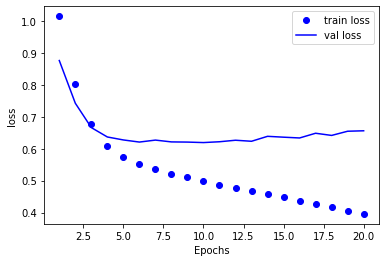

In [33]:
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_val, y_val)
reg_min = optimal_epoch(reg_history)
eval_metric(reg_model,reg_history,'loss')

#Base model vs. Reg model

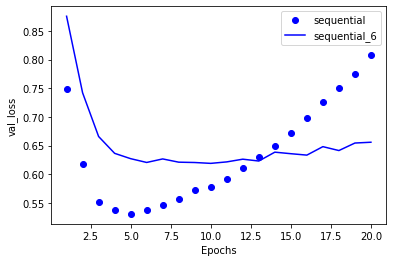

In [34]:
compare_models_by_metric(base_model,reg_model,base_history,reg_history,"val_loss")

#Dropout layers model

In [36]:
drop_model = Sequential()
drop_model.add(Dense(64,activation='relu', input_shape=(NB_WORDS,), name='Drop_model'))
drop_model.add(Dropout(.5))
drop_model.add(Dense(64,activation='relu'))
drop_model.add(Dropout(.5))
drop_model.add(Dense(3, activation='softmax'))

Minimum validation loss reached at 10


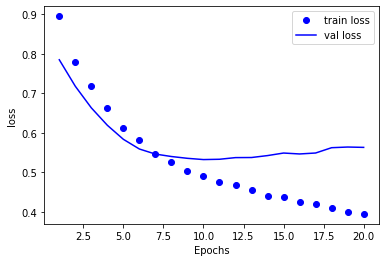

In [37]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_val, y_val)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history,'loss')

#Dropout vs. Baseline

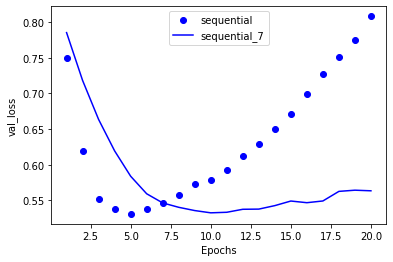

In [38]:
compare_models_by_metric(base_model,drop_model,base_history,drop_history,'val_loss')

#Training on full data and evaluation on test data

In [39]:
base_results = test_model(base_model,X_train_oh,y_train_oh,X_test_oh,y_test_oh,epoch_stop=base_min)
reduced_results = test_model(reduced_model,X_train_oh,y_train_oh,X_test_oh,y_test_oh,reduced_min)
reg_results = test_model(reg_model,X_train_oh,y_train_oh,X_test_oh,y_test_oh,reg_min)
drop_results = test_model(drop_model,X_train_oh,y_train_oh,X_test_oh,y_test_oh,drop_min)

46/46 [==============================] - 0s 1ms/step - loss: 0.8829 - accuracy: 0.7473

Test accuracy: 0.7472677826881409
46/46 [==============================] - 0s 1ms/step - loss: 0.5687 - accuracy: 0.7657

Test accuracy: 0.7657103538513184
46/46 [==============================] - 0s 1ms/step - loss: 0.7433 - accuracy: 0.7637

Test accuracy: 0.7636612057685852
46/46 [==============================] - 0s 1ms/step - loss: 0.6214 - accuracy: 0.7753

Test accuracy: 0.7752732038497925
